This notebook is for plotting the linear correlation between the grid-based FFT SASA result vs the change in Shrake-Rupley surface area as calculated by (SASA_receptor - SASA_ligand) - (SASA_complex)

In [12]:
import mdtraj as md
import bpmfwfft.grids as grids
import netCDF4 as nc
import numpy as np
from os import walk
import os
import socket
from bpmfwfft.grids import RecGrid
from bpmfwfft.grids import LigGrid
import copy
import pickle as p
from bpmfwfft.util import c_sasa

In [13]:
if socket.gethostname() == 'jim-Mint':
    ppi_path = '/media/jim/Research_TWO/FFT_PPI'
    home = '/home/jim'
else:
    ppi_path = '/mnt/fft/FFT_PPI'
    home = '/home/jtufts'

def get_directory_names(path):
    return sorted((name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))))


dir_path = f'{ppi_path}/2.redock/5.fft_sampling'
systems = get_directory_names(dir_path)

In [14]:
def get_system(receptor_prmtop, receptor_inpcrd, ligand_prmtop, ligand_inpcrd):
    receptor = md.load(receptor_inpcrd, top=receptor_prmtop)
    ligand = md.load(ligand_inpcrd, top=ligand_prmtop)
    return receptor, ligand

def get_complex(receptor_traj, ligand_traj, spacing, grid_displacement=np.array([0,0,0])):
    xyz_displacement = grid_displacement*spacing*.1
    for xyz in ligand_traj.xyz:
        xyz += xyz_displacement
    complex_top = receptor_traj.topology.join(ligand_traj.topology)
    complex_xyz = np.concatenate([receptor_traj.xyz, ligand_traj.xyz], axis=1)
    complex = md.Trajectory(complex_xyz, complex_top)
    return complex

In [15]:
def move_receptor_to_grid_center(receptor_traj, spacing, counts, origin=np.array([0.0,0.0,0.0])):
    """
    Moves receptor to be positioned inside of the "grid", this is intended to be a 1-to-1 recreation of the grid-based FFT system.
    Some rounding helps to keep the original complex accessible in the discrete grid space. Origin assumed as (0,0,0).
    
    receptor_traj: MDTraj Trajectory, single frame
    spacing: numpy array, shape (1,3)
    
    """

    spacing = spacing * 0.1
    # Calculate the lower and upper corners of the receptor box
    lower_receptor_corner = np.min(receptor_traj.xyz, axis=1)
    upper_receptor_corner = np.max(receptor_traj.xyz, axis=1)
    
    # Align lower and upper corners with the grid
    lower_receptor_corner_grid_aligned = np.floor((lower_receptor_corner - spacing) / spacing) * spacing
    upper_receptor_corner_grid_aligned = np.ceil((upper_receptor_corner + spacing) / spacing) * spacing
    
    # Calculate the grid-aligned receptor box center
    receptor_box_center_grid_aligned = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.0
    
    # Calculate the receptor box center without grid alignment
    receptor_box_center = (upper_receptor_corner + lower_receptor_corner) / 2.0
    
    # Calculate the grid center
    corner_crd = np.array((counts-1)*spacing, dtype=float)
    grid_center = (origin + corner_crd) / 2.0
    
    # Calculate the dimensions of the receptor box
    receptor_box_length = upper_receptor_corner - lower_receptor_corner
    receptor_box_length_grid_aligned = upper_receptor_corner_grid_aligned - lower_receptor_corner_grid_aligned
    
    # Adjust the receptor box center for grid alignment
    receptor_box_center = (upper_receptor_corner_grid_aligned + lower_receptor_corner_grid_aligned) / 2.0
    
    # Check if the receptor box center is not aligned with the grid
    grid_snap = np.mod(receptor_box_center, spacing)
    if np.any(grid_snap != 0):
        receptor_box_center += spacing - grid_snap
    
    displacement = grid_center - receptor_box_center

    for atom_ind in range(len(receptor_traj.xyz)):
        receptor_traj.xyz[atom_ind] += displacement
    return None

In [16]:
def move_ligand_to_lower_corner(ligand_traj, spacing, counts, origin=np.array([0.0,0.0,0.0])):
    """
    move ligand to near the grid lower corner
    store self._max_grid_indices and self._initial_com
    """
    import numpy as np

    # Find the minimum and maximum edge indices for x, y, and z coordinates
    min_edge_ind = np.array([ligand_traj.xyz[:, :, i].argmin() for i in range(3)], dtype=int)
    max_edge_ind = np.array([ligand_traj.xyz[:, :, i].argmax() for i in range(3)], dtype=int)

    # Get the minimum and maximum radii based on the edge indices
    ligand_atoms = list(ligand_traj.topology.atoms)
    min_edge_radii = np.array([md.geometry.sasa._ATOMIC_RADII[ligand_atoms[min_edge_ind[i]].element.symbol] for i in range(3)])
    max_edge_radii = np.array([md.geometry.sasa._ATOMIC_RADII[ligand_atoms[max_edge_ind[i]].element.symbol] for i in range(3)])
    
    spacing = spacing*0.1
    # Calculate lower and upper ligand corners
    lower_ligand_corner = (ligand_traj.xyz.min(axis=1) - min_edge_radii - .28 * 0.5).astype(float)
    upper_ligand_corner = (ligand_traj.xyz.max(axis=1) + max_edge_radii + .28 * 0.5).astype(float)

    # Align lower and upper ligand corners with the grid #FIXME: DEBUG np.ceil for lower corner
    lower_ligand_corner_grid_aligned = (np.floor((lower_ligand_corner - spacing) / spacing) * spacing).astype(float)
    upper_ligand_corner_grid_aligned = (np.ceil((upper_ligand_corner + spacing) / spacing) * spacing).astype(float)

    # Calculate ligand box lengths
    ligand_box_lengths = upper_ligand_corner_grid_aligned - lower_ligand_corner_grid_aligned
    
    # Check if any ligand box lengths are negative
    if np.any(ligand_box_lengths < 0):
        raise RuntimeError("One of the ligand box lengths is negative")

    # Calculate max grid indices
    max_grid_indices = np.ceil(ligand_box_lengths / spacing).astype(int)
    max_grid_indices = counts - (max_grid_indices)

    # Check if any max grid indices are less than or equal to 1
    if np.any(max_grid_indices <= 1):
        raise RuntimeError("At least one of the max grid indices is <= one")

    # Calculate displacement
    displacement = origin - lower_ligand_corner_grid_aligned

    # Translate ligand coordinates
    ligand_traj.xyz += displacement
    # print(f"Ligand translated by {displacement}")
    new_displacement = displacement

    # Calculate the absolute coordinates of the lower corner of the "ligand box" 
    lower_corner_origin = (ligand_traj.xyz.min(axis=1) - 1.5 * spacing).astype(float)

    # print(f"min_edge_ind:{min_edge_ind}, max_edge_index:{max_edge_ind}, min_edge_radii{min_edge_radii}, \
    # max_edge_radii{max_edge_radii}, lower_ligand_corner:{lower_ligand_corner}, lower_ligand_corner_grid_aligned:{lower_ligand_corner_grid_aligned}, \
    # upper_ligand_corner:{upper_ligand_corner}, upper_ligand_corner_grid_aligned{upper_ligand_corner_grid_aligned}, displacement{displacement}, max_grid_indicies:{max_grid_indices}, counts:{counts}")

    return None

In [17]:
from mdtraj.geometry import _geometry
def _get_molecule_sasa(traj, probe_radius=0.14, n_sphere_points=960):
    """
    return the per atom SASA of the target molecule in Angstroms
    probe radius is in nm...
    """
    atoms = list(traj.topology.atoms)
    atom_radii = np.array([md.geometry.sasa._ATOMIC_RADII[atoms[i].element.symbol] for i in range(len(atoms))])
    # atom_radii = self._prmtop["VDW_RADII"] / 10.
    radii = np.array(atom_radii, np.float32) + probe_radius
    dim1 = traj.xyz.shape[1]
    atom_mapping = np.arange(dim1, dtype=np.int32)
    out = np.zeros((traj.xyz.shape[0], dim1), dtype=np.float32)
    _geometry._sasa(traj.xyz, radii, int(n_sphere_points), atom_mapping, out)
    # out, centered_sphere_points = c_sasa(xyz, radii, int(n_sphere_points))
    # convert values from nm^2 to A^2
    out = out * 100.
    return out

(105, 1000, 3)


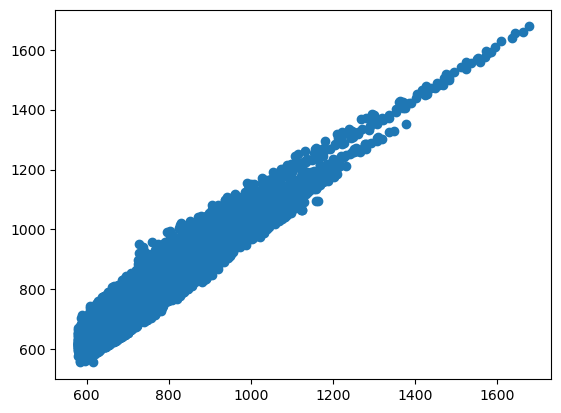

In [62]:
# calculate 2OOB sasa changes as test
rec_prmtop_test = '/mnt/fft/FFT_PPI/2.redock/1.amber/2OOB_A:B/receptor.prmtop'
rec_inpcrd_test = '/mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/receptor.inpcrd'

lig_prmtop_test = '/mnt/fft/FFT_PPI/2.redock/1.amber/2OOB_A:B/ligand.prmtop'
lig_inpcrd_test = '/mnt/fft/FFT_PPI/2.redock/2.minimize/2OOB_A:B/ligand.inpcrd'

fft_nc = nc.Dataset('/mnt/fft/FFT_PPI/2.redock/5.fft_sampling/2OOB_A:B/fft_sampling_maintest.nc')
# fft_nc = nc.Dataset('/mnt/sasa/FFT_PPI/2.redock/5.fft_sampling/2OOB_A:B/fft_sample.nc')
fft_crd = nc.Dataset('/mnt/fft/FFT_PPI/2.redock/3.ligand_rand_rot/2OOB_A:B/rotation.nc').variables["positions"][:]/10.
rec, lig = get_system(rec_prmtop_test, rec_inpcrd_test, lig_prmtop_test, lig_inpcrd_test)

# fft_dsasa = fft_nc.variables["sasa_resampled_energies"][:]/-0.005
fft_dsasa = fft_nc.variables["sasa_resampled_energies"][:]/-0.005
# fft_calc_dsasa = (fft_nc.variables["resampled_energies"][:]/0.005) - (fft_nc.variables["no_sasa_resampled_energies"][:]/0.005)
fft_vectors = fft_nc.variables["sasa_resampled_trans_vectors"][:]
# fft_vectors = fft_nc.variables["resampled_trans_vectors"][:]
spacing = fft_nc.variables["spacing"][:]
counts = fft_nc.variables["counts"][:]

x = []
y = []
move_receptor_to_grid_center(rec, spacing, counts)
print(fft_vectors.shape)
for i in range(fft_vectors.shape[0]):
    # for i in range(100):
    lig.xyz = fft_crd[i]
    for j in range(fft_vectors.shape[1]):
        move_ligand_to_lower_corner(lig, spacing, counts)
        lig.xyz += np.array(fft_vectors[i,j]*0.1*spacing)
        com = get_complex(rec, lig, spacing)
        # print(fft_dsasa[i,j], (md.shrake_rupley(rec).sum()+md.shrake_rupley(lig).sum())-md.shrake_rupley(com).sum(), (_get_molecule_sasa(lig).sum()+_get_molecule_sasa(rec).sum())-_get_molecule_sasa(com).sum())
        # com.save(f"/mnt/fft/FFT_PPI/2.redock/7.analysis/2OOB_A:B/sasa_test/lig_{i}_{j}.pdb")
        x.append(fft_dsasa[i,j])
        # y.append((md.shrake_rupley(rec).sum()+md.shrake_rupley(lig).sum())-md.shrake_rupley(com).sum())
        y.append((_get_molecule_sasa(lig).sum()+_get_molecule_sasa(rec).sum())-_get_molecule_sasa(com).sum())

import matplotlib.pyplot as plt

plt.scatter(x,y)
    




In [1]:
md.shrake_rupley(lig).sum()

NameError: name 'md' is not defined

In [ ]:
rec, lig = get_system(rec_prmtop_test, rec_inpcrd_test, lig_prmtop_test, lig_inpcrd_test)

grid_displacement = np.array([0,0,0])
xyz_displacement = grid_displacement*spacing*.1
for xyz in lig.xyz:
    xyz += xyz_displacement
complex_top = rec.topology.join(lig.topology)
complex_xyz = np.concatenate([rec.xyz, lig.xyz], axis=1)
complex = md.Trajectory(complex_xyz, complex_top)
for bond in complex.topology.bonds:
    print(bond)

In [60]:
print(len(list(lig.topology.atoms)), len(list(rec.topology.atoms)), len(list(lig.topology.atoms))+len(list(rec.topology.atoms)), len(list(complex.topology.atoms)))

777 1231 2008 2008


In [ ]:
import matplotlib.pyplot as plt
x = np.array(x)
y = np.array(y)
plt.scatter(x,y*100)

In [40]:
rec, lig = get_system(rec_prmtop_test, rec_inpcrd_test, lig_prmtop_test, lig_inpcrd_test)
lower_receptor_corner = np.min(rec.xyz, axis=1)
upper_receptor_corner = np.max(rec.xyz, axis=1)

print(lower_receptor_corner.shape, upper_receptor_corner.shape, rec.xyz.shape)

(1, 3) (1, 3) (1, 1231, 3)


In [71]:
a = md.load_pdb("/mnt/fft/lig.pdb")
b = md.load_pdb("/mnt/fft/FFT_PPI/2.redock/4.receptor_grid/2OOB_A:B/native_pose.pdb")

a.xyz - b.xyz

array([[[-0.05000019,  0.04999971,  0.04999971],
        [-0.04999971,  0.05000019,  0.05000019],
        [-0.05000019,  0.05000019,  0.04999971],
        ...,
        [-0.04999971,  0.04999971,  0.04999995],
        [-0.04999971,  0.05000019,  0.04999995],
        [-0.04999971,  0.04999971,  0.04999995]]], dtype=float32)

In [79]:
for rotation in fft_vectors[:100]:
    for fft_vector in rotation[:100]:
        if fft_vector == np.all([65, 85, 42]):
            print(fft_vector)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [66]:
# Main functions for concatenating grids, calculating sasa using Shrake-Rupley, retrieving results from FFT calculations for grid-based sasa, and plotting the results



if socket.gethostname() == 'jim-Mint':
    ppi_path = '/media/jim/Research_TWO/FFT_PPI'
    home = '/home/jim'
else:
    ppi_path = '/home/jtufts/Desktop/FFT_PPI'
    home = '/home/jtufts'

def rmsd(P: np.ndarray, Q: np.ndarray, **kwargs) -> float:
    diff = P - Q
    return np.sqrt((diff * diff).sum() / P.shape[0])

def _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file):
    rec_grid = RecGrid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, 
                        grid_nc_file, new_calculation=False)
    return rec_grid

def _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid):
    lig_grid = LigGrid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)
    return lig_grid

def get_top_scores(score, k):

	flat_score = score.flatten()
	flat_argp = np.argpartition(flat_score, -k)[-k:]

	top_scores = flat_score[flat_argp]
	top_scores.sort()
	translations = []
	trans_scores = []

	for score_val in top_scores:
	    t = np.where(score == score_val)
	    a = np.array(t)
	    if a.shape == (3,2):
	        for x,y,z in a.transpose():
	            x = np.array([x])
	            y = np.array([y])
	            z = np.array([z])
	            translations.append((x,y,z))
	            trans_scores.append(score[x,y,z])
	            # print((x,y,z),  score[x,y,z], cfft[x,y,z])
	    else:
	        translations.append(t)
	        trans_scores.append(score[t])

	return translations, trans_scores


def cat_grids(grid1, grid2):
    prmtop = cat_dictionaries(grid1._prmtop,grid2._prmtop)
    crd = cat_dictionaries(grid1._crd,grid2._crd)
    cat_grid = copy.deepcopy(grid1)
    cat_grid._prmtop = prmtop
    cat_grid._crd = crd
    return cat_grid

def cat_dictionaries(dict1, dict2):
    dict1_copy = copy.deepcopy(dict1)
    dict2_copy = copy.deepcopy(dict2)
    
    if isinstance(dict1_copy, dict):
        keys = list(dict1_copy.keys())
        for key in keys:
            # print(keys)
            # print(key)
            dict1_copy[key] = cat_values(dict1[key], dict2[key])
        return dict1_copy
    
    elif isinstance(dict1_copy, np.ndarray):
        return np.concatenate((dict1_copy,dict2_copy))

def cat_values(a1, a2):
    array1 = copy.deepcopy(a1)
    array2 = copy.deepcopy(a2)
    if isinstance(array1, np.ndarray):
        return np.concatenate((array1,array2))
    elif isinstance(array1, dict):
        return cat_dictionaries(array1, array2)
    elif isinstance(array1, (int, np.int64)):
        # print(f"{array1+array2}")
        return array1 + array2
    elif isinstance(array1, list):
        # print(type(array1))
        # print(f'array1:{len(array1)}, array2:{len(array2)}')
        array1.extend(array2)
        # print(f'complex:{len(array1)}, sum:{len(a1)+len(a2)}')
        return array1

def regplot(trans_scores, delta_sasas, colors, name, num, system):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    import math

    x = np.array(trans_scores)
    y = np.array(delta_sasas)
    C = np.array(colors)

    x = x.reshape((-1,1))

    model = LinearRegression().fit(x, y)
    r_sq = model.score(x, y)

    print('coefficient of determination:', r_sq)
    print('intercept:', model.intercept_)
    print('slope:', model.coef_)

    pred_y = np.zeros(len(y), dtype=float)
    for ind,point in enumerate(x):
        pred_y[ind] = point*model.coef_ + model.intercept_
    
        
    MSE = mean_squared_error(y, pred_y)
 
    RMSE = math.sqrt(MSE)

    # scatter plot
    fig, ax = plt.subplots()
    ax.scatter(x, y, 10, c=C, alpha=0.5, marker='o', cmap="hot",
            label="Shrake-Rupley GRID_SASA vs Delta SASA", edgecolors="black")
    # regression plot
    rx = np.linspace(x.min(), x.max(), 165)
    ry = model.coef_*rx + model.intercept_

    ax.plot(rx, ry, '-r', label=f'y={float(model.coef_):.4f}*x + {float(model.intercept_):.2f}')
    plt.xlabel("Shrake-Rupley GRID SASA SCORE")
    plt.ylabel("Delta_SASA (A^2)")
    ax.set_title(f'Shrake-Rupley Grid SASA score vs Shrake-Rupley R+L-C Delta SASA {chr(10)} System:{system} Rotation:{num}{chr(10)} R2: {r_sq}, RMSE: {RMSE}')
    ax.legend(loc='upper left')
    plt.savefig(f'{name}', dpi=360)


def get_grid_nc(system):
    if not os.path.exists(f"/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system}/sasa"):
        os.mkdir(f"/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system}/sasa")
    grid_path = f'{ppi_path}/2.redock/4.receptor_grid/{system}'
    grid_nc = '%s/shrakerupley.nc'%grid_path
    
    return grid_nc


def get_grids(system):

    grid_nc = get_grid_nc(system)
    #parsing some of the netcdf variables from grid.nc
    grid_variables = nc.Dataset(grid_nc, 'r').variables
    counts = nc.Dataset(grid_nc, 'r').variables["counts"][:]
    x = nc.Dataset(grid_nc, 'r').variables["x"][:]
    y = nc.Dataset(grid_nc, 'r').variables["y"][:]
    z = nc.Dataset(grid_nc, 'r').variables["z"][:]
    sasa = nc.Dataset(grid_nc, 'r').variables["sasa"][:]
    occupancy = nc.Dataset(grid_nc, 'r').variables["occupancy"][:]
    trans_crd = nc.Dataset(grid_nc, 'r').variables["trans_crd"][:]
    rec_disp = nc.Dataset(grid_nc, 'r').variables["displacement"][:]


    rec_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/receptor.prmtop"
    lj_sigma_scal_fact = 1.0
    rec_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/receptor.inpcrd"

    bsite_file = None
    grid_nc_file = f"{ppi_path}/2.redock/4.receptor_grid/{system}/shrakerupley.nc"

    lig_prmtop = f"{ppi_path}/2.redock/1.amber/{system}/ligand.prmtop"
    # lig_inpcrd = f"{ppi_path}/2.redock/2.minimze/2OOB_A:B/ligand.inpcrd"

    rot_nc = f"{ppi_path}/2.redock/3.ligand_rand_rot/{system}/rotation.nc"
    lig_rot = nc.Dataset(rot_nc, 'r').variables['positions']
    lig_inpcrd = f"{ppi_path}/2.redock/2.minimize/{system}/ligand.inpcrd"

    rho = 9.0
    rc_scale = 0.76
    rs_scale = 0.53
    rm_scale = 0.55
    lc_scale = 0.81
    ls_scale = 0.50
    lm_scale = 0.54

    rec_grid = _create_rec_grid(rec_prmtop, lj_sigma_scal_fact, rc_scale, rs_scale, rm_scale, rho, rec_inpcrd, bsite_file, grid_nc_file)

    lig_grid = _create_lig_grid(lig_prmtop, lj_sigma_scal_fact, lc_scale, ls_scale, lm_scale, lig_inpcrd, rec_grid)

    return rec_grid, lig_grid, sasa, occupancy, rec_disp, lig_rot 

def calc_rec_sasa(system):
    r_grid_path = f"/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/{system}/r_grid.p"
    if os.path.exists(r_grid_path):
        r_grid = p.load(open(f"/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/{system}/r_grid.p", "rb"))
    else:
        r_grid = np.zeros((occupancy.shape), dtype=np.float64)
        r_grid, r_areas = c_sasa(rec_grid._crd, rec_grid._prmtop["VDW_RADII"], rec_grid._spacing, 1.4, 960, r_grid)
        p.dump(r_grid, open(f"/media/jim/Research_TWO/FFT_PPI/2.redock/4.receptor_grid/{system}/r_grid.p", "wb"))
    return r_grid

def fft_plot(system):
    rec_grid, lig_grid, sasa, occupancy, rec_disp, lig_rot = get_grids(system)
    lig_grid._move_ligand_to_lower_corner()
    ref_disp = rec_disp - lig_grid._displacement*lig_grid._spacing
    lig_grid.translate_ligand(np.array(ref_disp))
    #crystal pose for rmsd
    ref = copy.deepcopy(lig_grid._crd)

    all_translations = [] 
    all_trans_scores = []
    all_delta_sasas = []
    all_colors = []

    rotations = {}
    
    r_grid = calc_rec_sasa(system)

    for i,rot_crd in enumerate(lig_rot):
        lig_grid._crd = np.array(rot_crd, dtype=np.float64)
        lig_grid._move_ligand_to_lower_corner()

        # Make new Shrake-Rupley SASA Grid
        l_grid = np.zeros(occupancy.shape, dtype=np.float64)
        l_grid, l_areas = c_sasa(lig_grid._crd, lig_grid._prmtop["VDW_RADII"], lig_grid._spacing, 1.4, 960, l_grid)

        names = ["occupancy", "sasa"]
        lgrid = lig_grid.get_ligand_grids(names, [0,0,0])
        r_ones = np.copy(sasa)
        l_ones = np.copy(lgrid["sasa"])

        r_ones[r_ones>0] = 1.
        l_ones[l_ones>0] = 1.

        # do FFT for grids
        lo_fft = np.fft.fftn(lgrid["occupancy"])
        ro_fft = np.fft.fftn(occupancy)
        occupancy_fft = np.fft.ifftn(ro_fft*lo_fft.conjugate())

        ls_fft = np.fft.fftn(l_grid)
        lone_fft = np.fft.fftn(l_ones)
        rs_fft = np.fft.fftn(r_grid)
        rone_fft = np.fft.fftn(r_ones)

        r_dsasa_fft = np.fft.ifftn(rs_fft*lone_fft.conjugate())
        l_dsasa_fft = np.fft.ifftn(rone_fft*ls_fft.conjugate())
        score = r_dsasa_fft.real + l_dsasa_fft.real

        score[occupancy_fft > 0.001] = 0.

        k = 1000  # number of scores to save
        translations, trans_scores = get_top_scores(score, k)
        all_translations.extend(translations)
        all_trans_scores.extend(trans_scores)

        delta_sasas = []
        colors = []
        for v,vector in enumerate(translations):
            vector = (np.array(vector).transpose()*lig_grid._spacing)[0]
            lig_grid._move_ligand_to_lower_corner()
            print(vector)
            lig_grid.translate_ligand(vector)
            com_grid = cat_grids(rec_grid, lig_grid)
            com_sasa = com_grid._get_molecule_sasa(0.14, 960).sum()
            l_sasa = lig_grid._get_molecule_sasa(0.14, 960).sum()
            r_sasa = rec_grid._get_molecule_sasa(0.14, 960).sum()
            d_sasa = (l_sasa + r_sasa) - com_sasa
            delta_sasas.append(d_sasa)
            rmsd_to_native = rmsd(ref, lig_grid._crd)
            colors.append(rmsd_to_native)

            all_delta_sasas.extend(delta_sasas)
            all_colors.extend(colors)

        name = f'/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system}/sasa/{i}.jpg'

        regplot(trans_scores, delta_sasas, colors, name, i, system)
        print('plot saved')
        values = {}
        values['translations'] = translations
        values['trans_scores'] = trans_scores
        values['delta_sasas'] = delta_sasas
        values['colors'] = colors
        p.dump(values, open( f"{name[:-4]}values.p", "wb" ) )
        rotations[i] = values
        del l_grid


    final = f'/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system}/sasa/{system}.jpg'
    p.dump(rotations, open(f"/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/{system}/sasa/rotations.p", "wb" ) )
    # regplot(all_trans_scores, all_delta_sasas, all_colors, final, "All")


from multiprocessing import Pool

def f(system):
    return fft_plot(system)

#MAIN SCRIPT, this is awful and lazy, I know. #FIXME

system_list = []
for root, dirs, files in walk("/mnt/fft/FFT_PPI/2.redock/4.receptor_grid", topdown=False):
   # for name in files:
   #    print(os.path.join(root, name))
    for name in dirs:
        # print(os.path.join(name))
        if name[0] != '.':
            system_list.append(name)

system_list.sort()

with Pool(22) as p:
    system_map = p.map(f, system_list)    
    for j, system in enumerate(system_map):
        print(f'Doing FFT and Plotting for {system_list[j]}.')

FileNotFoundError: [Errno 2] No such file or directory: '/media/jim/Research_TWO/FFT_PPI/2.redock/7.analysis/1A2K_C:AB/sasa'

In [54]:
!echo you abandoned me for so long 

you abandoned me for so long


In [56]:
!echo Hello! New World!


Hello! New World!
